# Benchmark Performance For Log Loss = Binary Cross Entropy

**Table of Contents** <a name="toc"></a>
- [1. Numpy vs different Cython implementations](#chapter_1)
  - [1.1 Implementation](#chapter_1_1)
  - [1.2. Simple Timings](#chapter_1_2)
  - [1.3 Benchmark Loss](#chapter_1_3)
  - [1.4 Benchmark Gradient](#chapter_1_4)
- [2. Numpy vs Loop Wrap - Numerical Stable Implementation](#chapter_2)
  - [2.1 Implementaion](#chapter_2_1)
  - [2.2 Benchmark Loss](#chapter_2_2)

In [1]:
%load_ext cython

In [2]:
from collections import OrderedDict
import numpy as np
from scipy.special import expit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from neurtu import delayed, timeit, Benchmark


# See https://github.com/mwaskom/seaborn/issues/1986
#g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height =5)
#g.map(plt.errorbar, "N", "mean", yerr=df.wall_time.reset_index()['std']);

# This works
# See https://stackoverflow.com/a/30428808
def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, yerr=yerr, kind="line", ax=ax, **kwargs)

## 1. Numpy vs different Cython implementations <a name="chapter_1"></a>

### 1.1 Implementation <a name="chapter_1_1"></a>
With $\eta = \mathrm{raw\_prediction}$ and $\mathrm{y_{pred}} = expit(\eta) = \frac{exp(\eta)}{1 + exp(\eta)}$ we have
$$log\_loss =  log(1 + exp(\eta)) - y_{true} \eta$$

In [3]:
# numpy ufunc version
# Note: log1p(exp(x)) is faster than logaddexp(x)
def np_logloss(y_true, raw):
    # logaddexp(0, x) = log(1 + exp(x))
    # return np.logaddexp(0, raw) - y_true * raw
    #
    # numerically stable, but slower
    # pos = raw > 0
    # out = - y_true * raw
    # out[pos] += raw[pos] + np.log1p(np.exp(-raw[pos]))
    # out[~pos] += np.log1p(np.exp(raw[~pos]))
    # return out
    #
    # return np.where(raw >= 0, raw + np.log1p(np.exp(-raw)) - y_true * raw, np.log1p(np.exp(raw)) - y_true * raw)
    #
    # fast, but unstable for raw > 700
    return np.log1p(np.exp(raw)) - y_true * raw
    

def np_gradient(y_true, raw):
    return expit(raw) - y_true

In [4]:
%%cython -3
# distutils: extra_compile_args = -O3
# cython: cdivision=True
# cython: boundscheck=False
# cython: wraparound=False

import cython
from cython.parallel import prange
import numpy as np

from libc.math cimport exp, log, log1p
cimport numpy as np
from scipy.special.cython_special cimport expit

np.import_array()


ctypedef double (*fpointer)(double, double) nogil


cdef void generic_loop(fpointer f, double[::1] y_true, double[::1] raw, double[::1] out):
    cdef:
        int i
        int size = y_true.shape[0]
    with nogil:
        for i in range(size):
            out[i] = f(y_true[i], raw[i])

### 1. C level functions
cdef double c_logloss(double y_true, double raw) nogil:
    if raw <= 0:
        return log1p(exp(raw)) - y_true * raw
    else:
        # log(1 + exp(x)) = x + log(1 + exp(-x))
        return raw + log1p(exp(-raw)) - y_true * raw

    
cdef inline double c_gradient(double y_true, double raw) nogil:
        return expit(raw) - y_true


### 2. ndarray via loop over C level functions
def p_logloss(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples
        int i
        cdef double[::1] out = np.empty_like(y_true)
    
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        out[i] = c_logloss(y_true[i], raw[i])
        
    return out


def p_gradient(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples
        int i
        cdef double[::1] out = np.empty_like(y_true)
    
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        out[i] = c_gradient(y_true[i], raw[i])
        
    return out


### 3. ndarray via generic loop, i.e. function pointer to C level functions
def p_logloss_generic(double[::1] y_true, double[::1] raw):
    cdef:
        cdef double[::1] out = np.empty_like(y_true)
    
    generic_loop(c_logloss, y_true, raw, out)        
    return out


def p_gradient_generic(double[::1] y_true, double[::1] raw):
    cdef:
        cdef double[::1] out = np.empty_like(y_true)
    
    generic_loop(c_gradient, y_true, raw, out)        
    return out


### 4. Class implementation, similar to 1. and 2.
cdef class Logloss():
    
    @staticmethod
    cdef double static_logloss(double y_true, double raw) nogil:
        if raw <= 0:
            return log1p(exp(raw)) - y_true * raw
        else:
            # log(1 + exp(x)) = x + log(1 + exp(-x))
            return raw + log1p(exp(-raw)) - y_true * raw
    
    @staticmethod
    cdef double static_gradient(double y_true, double raw) nogil:
            return expit(raw) - y_true

    def loss(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)
        
        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = Logloss.static_logloss(y_true[i], raw[i])
            
        return np.asarray(out)
    
    def gradient(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)
        
        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = Logloss.static_gradient(y_true[i], raw[i])
            
        return np.asarray(out)

    def loss_generic(self, double[::1] y_true, double[::1] raw):
        cdef:
            cdef double[::1] out = np.empty_like(y_true)

        generic_loop(self.static_logloss, y_true, raw, out)
        return out
    
    def gradient_generic(self, double[::1] y_true, double[::1] raw):
        cdef:
            cdef double[::1] out = np.empty_like(y_true)

        generic_loop(self.static_gradient, y_true, raw, out)
        return out


### 5. Class using virtual inheritance, i.e. loop in base class
# is inherited to derived class
cdef class BaseLoss():

    cdef double _loss(self, double y_true, double raw) nogil:
        return 1.
    
    cdef double _gradient(self, double y_true, double raw) nogil:
        return 1.

    def loss(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)

        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = self._loss(y_true[i], raw[i])
            
        return np.asarray(out)
    
    def gradient(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)

        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = self._gradient(y_true[i], raw[i])
            
        return np.asarray(out)


cdef class Logloss_virtual(BaseLoss):

    cdef double _loss(self, double y_true, double raw) nogil:
        if raw <= 0:
            return log1p(exp(raw)) - y_true * raw
        else:
            # log(1 + exp(x)) = x + log(1 + exp(-x))
            return raw + log1p(exp(-raw)) - y_true * raw
        
    cdef double _gradient(self, double y_true, double raw) nogil:
        return expit(raw) - y_true

In [5]:
%%cython -3
# distutils: language = c++
# distutils: extra_compile_args = -O3
# cython: cdivision=True
# cython: boundscheck=False
# cython: wraparound=False


### 6. C++ template function loop wrapper
# We use functors, i.e. structs, in order
# to be sure, that the function call inside
# the template function gets inlined.
# See https://stackoverflow.com/a/2156899
#
# For further tricks, see also
# https://stackoverflow.com/questions/53582945/wrapping-c-code-with-function-pointer-as-template-parameter-in-cython

import cython
import numpy as np

cimport numpy as np
np.import_array()


cdef extern from *:
    """
#include <cmath>
#ifdef _OPENMP
#include <omp.h>
#endif /* _OPENMP */


inline double expit(double x) {
    return 1 / (1 + std::exp(-x));
};


struct cpp_logloss {
    double operator()(double y_true, double raw) {
        if (raw <= 0) {
            return std::log1p(std::exp(raw)) - y_true * raw;
        } else {
            // log(1 + exp(x)) = x + log(1 + exp(-x))
            return raw + std::log1p(std::exp(-raw)) - y_true * raw;
        }
    }
};

    
struct cpp_gradient {
    inline double operator()(double y_true, double raw) {
        return expit(raw) - y_true;
    }
};
   
   
    
template<typename F>
void loop_template(F f, double* y_true, double* raw, double* out, int n_samples) {
    for(int i = 0; i < n_samples; ++i){
        out[i] = f(y_true[i], raw[i]);
    }
}
    """
    void loop_template[F](F, double*, double*, double*, int)
    cppclass cpp_logloss:
        double operator()(double, double)
    cppclass cpp_gradient:
        double operator()(double, double)


def p_logloss_template(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples = y_true.shape[0]
        cdef double[::1] out = np.empty_like(y_true)
        cpp_logloss f

    loop_template(f, &y_true[0], &raw[0], &out[0], n_samples)
    return out


def p_gradient_template(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples = y_true.shape[0]
        cdef double[::1] out = np.empty_like(y_true)
        cpp_gradient f
    
    loop_template(f, &y_true[0], &raw[0], &out[0], n_samples)        
    return out

### 1.2. Simple Timings <a name="chapter_1_2"></a>
[back to TOC](#toc)

In [6]:
rng = np.random.default_rng(0)
y_true = rng.binomial(1, 0.5, size=100_000).astype(np.float64)
raw = rng.standard_normal(100_000, dtype=np.float64)

In [7]:
[np.sum(np_logloss(y_true, raw) - p_logloss(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - p_logloss_generic(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - Logloss().loss(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - Logloss().loss_generic(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - Logloss_virtual().loss(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - p_logloss_template(y_true, raw)),
]

[1.9872992140790302e-14,
 1.9872992140790302e-14,
 1.9872992140790302e-14,
 1.9872992140790302e-14,
 1.9872992140790302e-14,
 1.9872992140790302e-14]

In [8]:
%%timeit -r10 -n100
np_logloss(y_true, raw)

1.65 ms ± 308 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [9]:
%%timeit -r10 -n100
p_logloss(y_true, raw)

2.71 ms ± 88.2 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [10]:
%%timeit -r10 -n100
p_logloss_generic(y_true, raw)

2.64 ms ± 73.6 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [11]:
%%timeit -r10 -n100
Logloss().loss(y_true, raw)

2.65 ms ± 52.3 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [12]:
%%timeit -r10 -n100
Logloss().loss_generic(y_true, raw)

2.78 ms ± 92.8 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [13]:
%%timeit -r10 -n100
Logloss_virtual().loss(y_true, raw)

2.82 ms ± 77 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [14]:
%%timeit -r10 -n100
p_logloss_template(y_true, raw)

2.69 ms ± 101 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [15]:
[np.sum(np_gradient(y_true, raw) - p_gradient(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - p_gradient_generic(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - Logloss().gradient(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - Logloss().gradient_generic(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - Logloss_virtual().gradient(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - p_gradient_template(y_true, raw)),
]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [17]:
%%timeit -r10 -n500
np_gradient(y_true, raw)

681 µs ± 25.4 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [18]:
%%timeit -r10 -n500
p_gradient(y_true, raw)

736 µs ± 19.1 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [19]:
%%timeit -r10 -n500
p_gradient_generic(y_true, raw)

730 µs ± 10.9 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [20]:
%%timeit -r10 -n500
Logloss().gradient(y_true, raw)

736 µs ± 16.1 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [21]:
%%timeit -r10 -n500
Logloss().gradient_generic(y_true, raw)

855 µs ± 17.4 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [22]:
%%timeit -r10 -n500
Logloss_virtual().gradient(y_true, raw)

881 µs ± 15.7 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [23]:
%%timeit -r10 -n500
p_gradient_template(y_true, raw)

574 µs ± 13.9 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


### 1.3 Benchmark Loss <a name="chapter_1_3"></a>
[back to TOC](#toc)

In [24]:
n_samples = 1000_000
rng = np.random.default_rng(42)
y_true = rng.standard_normal(n_samples)
raw = rng.standard_normal(n_samples)

func_list = [(np_logloss, "np_logloss"),
             (p_logloss, "p_logloss"),
             (p_logloss_generic, "p_logloss_generic"),
             (Logloss().loss, "Logloss().loss"),
             (Logloss().loss_generic, "Logloss().loss_generic"),
             (Logloss_virtual().loss, "Logloss_virtual().loss"),
             (p_logloss_template, "p_logloss_template"),
            ]

def benchmark_cases():
    for N in np.logspace(np.log10(10), np.log10(n_samples), 10).astype('int'):
        for func, name in func_list:
            tags = OrderedDict(N=N, function=name)
            yield delayed(func, tags=tags)(y_true[:N], raw[:N])

In [25]:
%%time
bench = Benchmark(wall_time={'number': 1}, peak_memory=True, repeat=20)
df_loss = bench(benchmark_cases())

  0%|          | 0/2800 [00:00<?, ?it/s]

CPU times: user 12min 54s, sys: 53.6 s, total: 13min 47s
Wall time: 14min 27s


In [26]:
df = df_loss
df.head()

wall_time                         peak_memory       \
                               mean       max           std        mean  max   
N  function                                                                    
10 Logloss().loss          0.000006  0.000007  2.604007e-07         0.0  0.0   
   Logloss().loss_generic  0.000005  0.000005  1.631518e-07         0.0  0.0   
   Logloss_virtual().loss  0.000006  0.000007  2.224553e-07         0.0  0.0   
   np_logloss              0.000003  0.000005  4.021064e-07         0.0  0.0   
   p_logloss               0.000005  0.000005  1.789145e-07         0.0  0.0   

                                
                           std  
N  function                     
10 Logloss().loss          0.0  
   Logloss().loss_generic  0.0  
   Logloss_virtual().loss  0.0  
   np_logloss              0.0  
   p_logloss               0.0

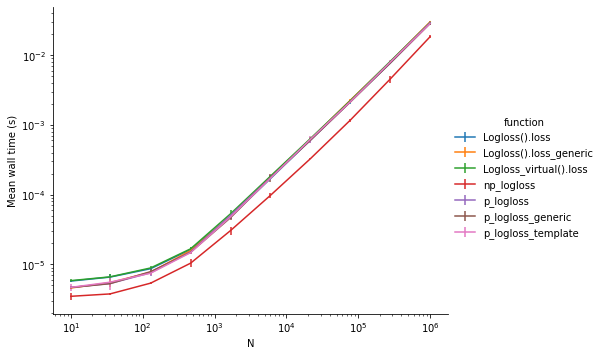

In [27]:
g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean wall time (s)")
g.add_legend()

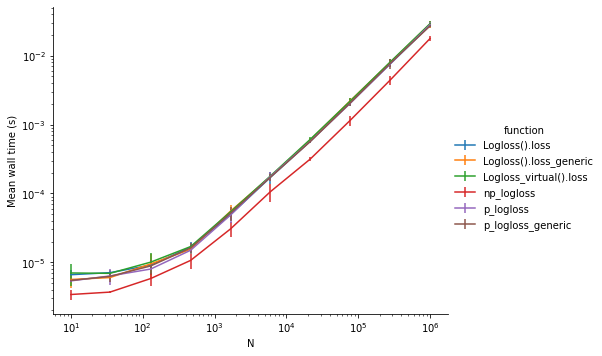

In [23]:
# OLD PLOT
#g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height=5, aspect=4/3)
#g.map_dataframe(errplot, "N", "mean", "std")
#g.set(xscale="log", yscale="log")
#g.set_axis_labels(y_var="Mean wall time (s)")
#g.add_legend()

Error propagation: $\sigma^2(x/y) \approx \left(\frac{\partial}{\partial x}\frac{x}{y}\right)^2 \sigma_x^2 + \left(\frac{\partial}{\partial y}\frac{x}{y}\right)^2 \sigma_y^2
= \frac{1}{y^2} \sigma_x^2 + \frac{x^2}{y^4} \sigma_y^2 $

In [28]:
df_reference = df.wall_time.reset_index().query("function == 'np_logloss'")
df_plot = pd.merge(df.wall_time.reset_index(), df_reference, on='N', suffixes=('', '_np'))
df_plot['std'] = np.sqrt(df_plot['std']**2 / df_plot['mean_np']**2
                         + df_plot['mean']**2 / df_plot['mean_np']**4 * df_plot['std_np']**2)
df_plot['mean'] = df_plot['mean'] / df_plot['mean_np']
df_plot = df_plot.loc[:, ['N', 'function', 'mean', 'std']]
df_plot.head()

,N,function,mean,std
0,10,Logloss().loss,1.653021,0.205255
1,10,Logloss().loss_generic,1.315074,0.159113
2,10,Logloss_virtual().loss,1.678471,0.204323
3,10,np_logloss,1.000000,0.163503
4,10,p_logloss,1.340872,0.163335


In [29]:
# shift N slightly to make visualization easier
df_plot.loc[df_plot['function'] =='Logloss().loss', 'N'] *= 0.9
df_plot.loc[df_plot['function'] =='Logloss().loss_generic', 'N'] *= 0.95
df_plot.loc[df_plot['function'] =='Logloss_virtual().loss', 'N'] *= 1.00
df_plot.loc[df_plot['function'] =='p_logloss', 'N'] *= 1.05
df_plot.loc[df_plot['function'] =='p_logloss_generic', 'N'] *= 1.10
df_plot.loc[df_plot['function'] =='p_logloss_template', 'N'] *= 1.15

Text(0.5, 0.98, 'Ratio of wall time compared to np_logloss')

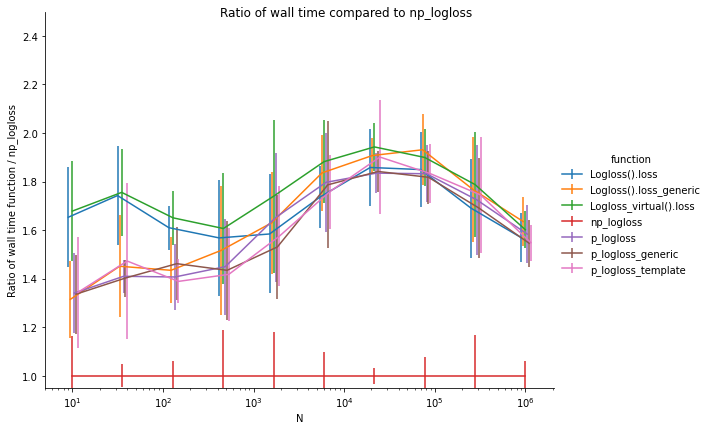

In [30]:
g = sns.FacetGrid(df_plot, hue="function", height=6, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(ylim=(0.95, 2.5))
g.set(xscale="log")
g.set_axis_labels(y_var="Ratio of wall time function / np_logloss")
g.add_legend()
g.fig.suptitle("Ratio of wall time compared to np_logloss")

Text(0.5, 0.98, 'Ratio of wall time compared to np_logloss')

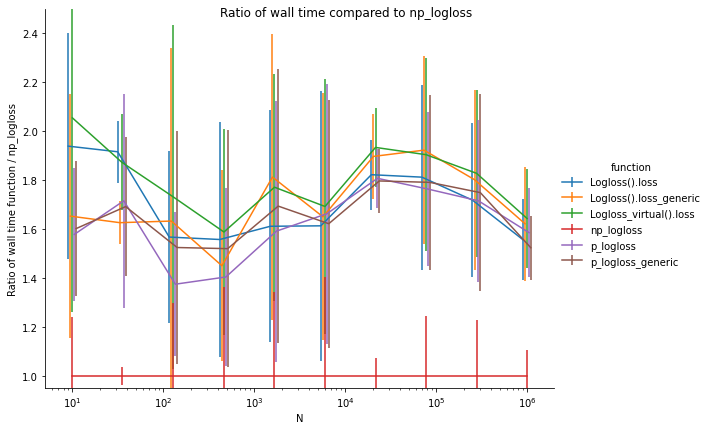

In [41]:
# OLD PLOT
#g = sns.FacetGrid(df_plot, hue="function", height=6, aspect=4/3)
#g.map_dataframe(errplot, "N", "mean", "std")
#g.set(ylim=(0.95, 2.5))
#g.set(xscale="log")
#g.set_axis_labels(y_var="Ratio of wall time function / np_logloss")
#g.add_legend()
#g.fig.suptitle("Ratio of wall time compared to np_logloss")

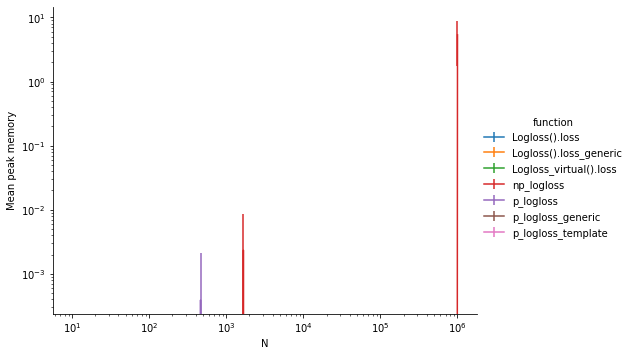

In [31]:
g = sns.FacetGrid(df.peak_memory.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean peak memory")
g.add_legend()

### 1.4 Benchmark Gradient <a name="chapter_1_4"></a>
[back to TOC](#toc)

In [32]:
n_samples = 1000_000
rng = np.random.default_rng(42)
y_true = rng.standard_normal(n_samples)
raw = rng.standard_normal(n_samples)

func_list = [(np_gradient, "np_gradient"),
             (p_gradient, "p_gradient"),
             (p_gradient_generic, "p_gradient_generic"),
             (Logloss().gradient, "Logloss().gradient"),
             (Logloss().gradient_generic, "Logloss().gradient_generic"),
             (Logloss_virtual().gradient, "Logloss_virtual().gradient"),
             (p_gradient_template, "p_gradient_template"),
            ]

def benchmark_cases():
    for N in np.logspace(np.log10(10), np.log10(n_samples), 10).astype('int'):
        for func, name in func_list:
            tags = OrderedDict(N=N, function=name)
            yield delayed(func, tags=tags)(y_true[:N], raw[:N])

In [33]:
%%time
bench = Benchmark(wall_time={'number': 1}, peak_memory=True, repeat=20)
df_gradient = bench(benchmark_cases())

  0%|          | 0/2800 [00:00<?, ?it/s]

CPU times: user 12min 5s, sys: 1min 8s, total: 13min 14s
Wall time: 14min 20s


In [34]:
df = df_gradient

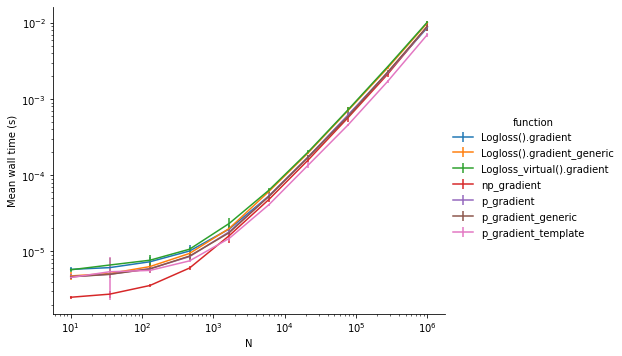

In [35]:
g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean wall time (s)")
g.add_legend()

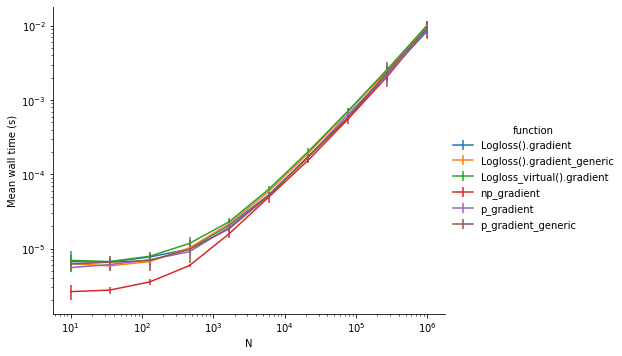

In [31]:
# OLD PLOT
#g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height=5, aspect=4/3)
#g.map_dataframe(errplot, "N", "mean", "std")
#g.set(xscale="log", yscale="log")
#g.set_axis_labels(y_var="Mean wall time (s)")
#g.add_legend()

In [36]:
df_reference = df.wall_time.reset_index().query("function == 'np_gradient'")
df_plot = pd.merge(df.wall_time.reset_index(), df_reference, on='N', suffixes=('', '_np'))
df_plot['std'] = np.sqrt(df_plot['std']**2 / df_plot['mean_np']**2
                         + df_plot['mean']**2 / df_plot['mean_np']**4 * df_plot['std_np']**2)
df_plot['mean'] = df_plot['mean'] / df_plot['mean_np']
df_plot = df_plot.loc[:, ['N', 'function', 'mean', 'std']]
df_plot.head()

,N,function,mean,std
0,10,Logloss().gradient,2.320525,0.183392
1,10,Logloss().gradient_generic,1.904827,0.237360
2,10,Logloss_virtual().gradient,2.292721,0.163917
3,10,np_gradient,1.000000,0.070205
4,10,p_gradient,1.863877,0.156485


In [37]:
# shift N slightly to make visualization easier
df_plot.loc[df_plot['function'] =='Logloss().gradient', 'N'] *= 0.9
df_plot.loc[df_plot['function'] =='Logloss().gradient_generic', 'N'] *= 0.95
df_plot.loc[df_plot['function'] =='Logloss_virtual().gradient', 'N'] *= 1.00
df_plot.loc[df_plot['function'] =='p_gradient', 'N'] *= 1.05
df_plot.loc[df_plot['function'] =='p_gradient_generic', 'N'] *= 1.10
df_plot.loc[df_plot['function'] =='p_gradient_template', 'N'] *= 1.15

Text(0.5, 0.98, 'Ratio of wall time compared to np_gradient')

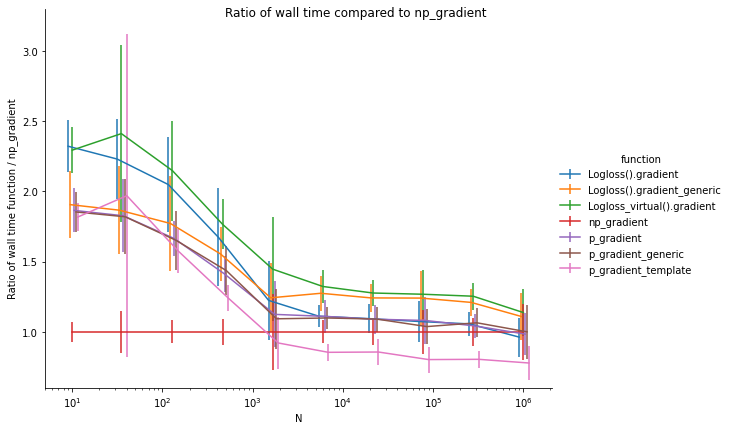

In [38]:
g = sns.FacetGrid(df_plot, hue="function", height=6, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log")
g.set(ylim=(0.6, 3.3))
g.set_axis_labels(y_var="Ratio of wall time function / np_gradient")
g.add_legend()
g.fig.suptitle("Ratio of wall time compared to np_gradient")

**Note:** This good performance of `p_gradient_template` might come from the fact that expit is an inline function in this case.

Text(0.5, 0.98, 'Ratio of wall time compared to np_gradient')

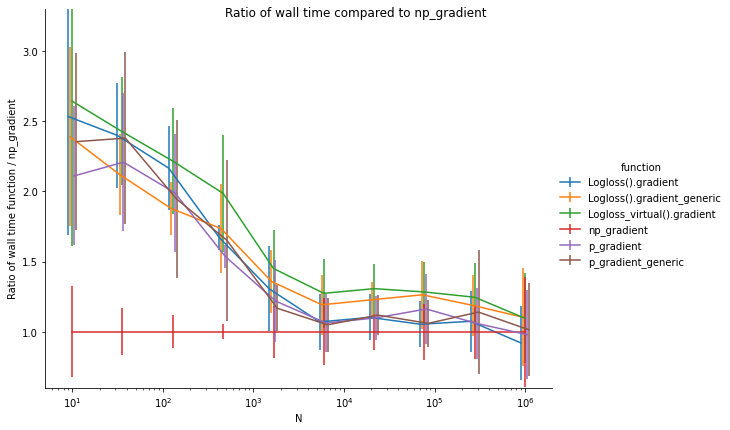

In [50]:
# OLD PLOT
#g = sns.FacetGrid(df_plot, hue="function", height=6, aspect=4/3)
#g.map_dataframe(errplot, "N", "mean", "std")
#g.set(xscale="log")
#g.set(ylim=(0.6, 3.3))
#g.set_axis_labels(y_var="Ratio of wall time function / np_gradient")
#g.add_legend()
#g.fig.suptitle("Ratio of wall time compared to np_gradient")

/Users/lorentzen/github/python3_general/lib/python3.7/site-packages/seaborn/axisgrid.py:49: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set(**kwargs)


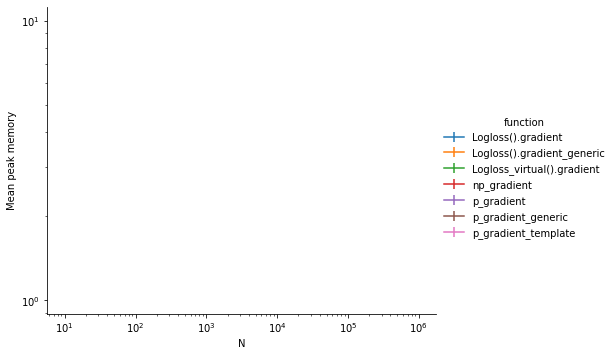

In [39]:
g = sns.FacetGrid(df.peak_memory.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean peak memory")
g.add_legend()

## 2. Numpy vs Loop Wrap - Numerical Stable Implementation <a name="chapter_2"></a>
[back to TOC](#toc)

See http://fa.bianp.net/blog/2019/evaluate_logistic/ and https://cran.r-project.org/web/packages/Rmpfr/vignettes/log1mexp-note.pdf as references on who to implement log loss in a numerically stable way.

### 2.1 Implementaion <a name="chapter_2_1"></a>
[back to TOC](#toc)

In [4]:
# 1. numpy ufunc version, this time the stable version
# Numerically stable log(1 + exp(x))
def np_log1pexp(x):
    return np.piecewise(x,
                        [x <= -37, (-37 < x) & (x <= 18), (18 < x) & (x <= 33.3), x > 33.3],
                        [lambda x: np.exp(x),
                         lambda x: np.log1p(np.exp(x)),
                         lambda x: x + np.exp(-x),
                         lambda x: x])
def np_logloss_stable(y_true, raw):
    # np.log1p(np.exp(raw)) - y_true * raw
    return np_log1pexp(raw) - y_true * raw

In [5]:
%%cython -3
# distutils: extra_compile_args = -O3
# cython: cdivision=True
# cython: boundscheck=False
# cython: wraparound=False

# Compiler flags to detect non-vetorized loops:
# Sebastien Ponce "Practical Vectorization" CERN 2019
# https://indico.cern.ch/event/771113/contributions/3203712/attachments/1746730/3022094/PracticalVectorization.pres.pdf
# icc: -vec-report=5
# clang: -Rpass-missed=loop-vectorize -Rpass-analysis=loop-vectorize
# gcc: -fopt-info-vec-missed

import cython
from cython.parallel import prange
import numpy as np

from libc.math cimport exp, log, log1p
cimport numpy as np
from scipy.special.cython_special cimport expit

np.import_array()


ctypedef double (*fpointer)(double, double) nogil


cdef void generic_loop(fpointer f, double[:] y_true, double[::1] raw, double[::1] out):
    cdef:
        int i
        int size = y_true.shape[0]
    with nogil:
        for i in range(size):
            out[i] = f(y_true[i], raw[i])
            
            
cdef double generic_sum(fpointer f, double[:] y_true, double[::1] raw):
    cdef:
        int i
        int size = y_true.shape[0]
        double out = 0.
    with nogil:
        for i in range(size):
            out += f(y_true[i], raw[i])
        return out


# Numerically stable log(1 + exp(x))
cdef inline double log1pexp(double x) nogil:
    if x <= -37:
        return exp(x)
    elif x <= 18:
        return log1p(exp(x))
    elif x <= 33.3:
        return x + exp(-x)
    else:
        return x


cdef double c_logloss(double y_true, double raw) nogil:
        return log1pexp(raw) - y_true * raw


### 2. ndarray via loop over C level functions
def p_logloss_stable(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples
        int i
        cdef double[::1] out = np.empty_like(y_true)
    
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        out[i] = c_logloss(y_true[i], raw[i])
        
    return out


### 3. Class implementation via generic loop wrapper
# Note: No F- or C-contiguity expected for y_true
#       In real life, y_true might be a train split.
cdef class Logloss_stable():

    def loss_generic(self, double[:] y_true, double[::1] raw):
        cdef:
            cdef double[::1] out = np.empty_like(y_true)

        generic_loop(c_logloss, y_true, raw, out)
        return out
    
    def loss_generic_sum(self, double[:] y_true, double[::1] raw):
        return generic_sum(c_logloss, y_true, raw)

In [6]:
%%cython -3
# distutils: language = c++
# distutils: extra_compile_args = -O3
# cython: cdivision=True
# cython: boundscheck=False
# cython: wraparound=False


### 4. C++ template function loop wrapper
# We use functors, i.e. structs, in order
# to be sure, that the function call inside
# the template function gets inlined.
# See https://stackoverflow.com/a/2156899
#
# For further tricks, see also
# https://stackoverflow.com/questions/53582945/wrapping-c-code-with-function-pointer-as-template-parameter-in-cython

import cython
import numpy as np

cimport numpy as np
np.import_array()


cdef extern from *:
    """
#include <cmath>
#ifdef _OPENMP
#include <omp.h>
#endif /* _OPENMP */


inline double cpp_log1pexp(double x) {
    if (x <= -37) {
        return std::exp(x);
    } else if (x <= 18) {
        return std::log1p(std::exp(x));
    } else if (x <= 33.3) {
        return x + std::exp(-x);
    } else {
        return x;
    }
};


struct cpp_logloss {
    /* inline here has no effect, it is already inlined */
    double operator()(double y_true, double raw) {
        return cpp_log1pexp(raw) - y_true * raw;
    }
};


template<typename F>
void loop_template(F f, double* y_true, double* raw, double* out, int n_samples) {
    for(int i = 0; i < n_samples; ++i) {
        out[i] = f(y_true[i], raw[i]);
    }
}

template<typename F>
double sum_template(F f, double* y_true, double* raw, int n_samples) {
    double out = 0;
    for(int i = 0; i < n_samples; ++i) {
        out += f(y_true[i], raw[i]);
    }
    return out;
}
    """
    void loop_template[F](F, double*, double*, double*, int) nogil
    double sum_template[F](F, double*, double*, int) nogil
    cppclass cpp_logloss:
        double operator()(double, double) nogil


def p_logloss_stable_template(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples = y_true.shape[0]
        cdef double[::1] out = np.empty_like(y_true)
        cpp_logloss f
    
    with nogil:
        loop_template(f, &y_true[0], &raw[0], &out[0], n_samples)
    return out


def p_logloss_stable_sum_template(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples = y_true.shape[0]
        cpp_logloss f
        double out
    
    with nogil:
        out = sum_template(f, &y_true[0], &raw[0], n_samples)
    return out

In [7]:
rng = np.random.default_rng(0)
y_true = rng.binomial(1, 0.5, size=100_000).astype(np.float64)
raw = 20 * rng.standard_normal(100_000, dtype=np.float64)  # make sure some values are <= -37 and > 33

In [8]:
raw.min(), raw.max()

(-91.87980390791544, 85.34683410460212)

In [9]:
# Same result on simple input
np_logloss(0.2, 0.5) - np_logloss_stable(0.2, 0.5)

0.0

In [10]:
np.sum(np.abs(np_logloss(y_true, raw) - np_logloss_stable(y_true, raw)))

5.826450433232822e-13

In [11]:
np.sum(np.abs(np_logloss(y_true, raw) - p_logloss_stable_template(y_true, raw)))

5.826450433232822e-13

In [12]:
%%timeit -r20 -n50
np_logloss(y_true, raw)

1.61 ms ± 95.9 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [13]:
%%timeit -r20 -n50
np_logloss_stable(y_true, raw)

3.27 ms ± 128 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [14]:
%%timeit -r20 -n50
p_logloss_stable(y_true, raw)

2.19 ms ± 87.3 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [15]:
%%timeit -r20 -n50
Logloss_stable().loss_generic(y_true, raw)

2.24 ms ± 87.6 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [17]:
%%timeit -r20 -n50
p_logloss_stable_template(y_true, raw)

2.32 ms ± 74.8 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


**Note: This time the generic loop is faster than numpy implementation.**<br>
Note also that this time `y_true` is not required to be C-contiguous in `Logloss_stable().loss_generic`, while is still is C-contiguous in `p_logloss_stable`.

In [18]:
np.sum(np_logloss_stable(y_true, raw)), Logloss_stable().loss_generic_sum(y_true, raw), p_logloss_stable_sum_template(y_true, raw)

(800208.506890483, 800208.5068904647, 800208.5068904647)

In [19]:
%%timeit -r20 -n50
np.sum(np_logloss_stable(y_true, raw))

3.33 ms ± 138 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [20]:
%%timeit -r20 -n50
Logloss_stable().loss_generic_sum(y_true, raw)

2.24 ms ± 57.5 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [21]:
%%timeit -r20 -n50
p_logloss_stable_sum_template(y_true, raw)

2.27 ms ± 88.3 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


**Note: numpy.sum() is so fast, there is no need to implement a separate "loop sum wrapper".**

### 2.2 Benchmark Loss <a name="chapter_2_2"></a>
[back to TOC](#toc)

In [22]:
n_samples = 1000_000
rng = np.random.default_rng(42)
y_true = rng.binomial(1, 0.5, size=n_samples).astype(np.float64)
raw = 20 * rng.standard_normal(n_samples, dtype=np.float64)

func_list = [(np_logloss_stable, "np_logloss_stable"),
             (p_logloss_stable, "p_logloss_stable"),
             (Logloss_stable().loss_generic, "Logloss_stable().loss_generic"),
             (p_logloss_stable_template, "p_logloss_stable_template"),
            ]

def benchmark_cases():
    for N in np.logspace(np.log10(10), np.log10(n_samples), 10).astype('int'):
        for func, name in func_list:
            tags = OrderedDict(N=N, function=name)
            yield delayed(func, tags=tags)(y_true[:N], raw[:N])

In [23]:
%%time
bench = Benchmark(wall_time={'number': 1}, peak_memory=True, repeat=20)
df_loss_stable = bench(benchmark_cases())

  0%|          | 0/1600 [00:00<?, ?it/s]

CPU times: user 7min 18s, sys: 40.5 s, total: 7min 59s
Wall time: 8min 21s


In [24]:
df = df_loss_stable
df.head()

wall_time                          \
                                      mean       max           std   
N  function                                                          
10 Logloss_stable().loss_generic  0.000005  0.000005  1.329708e-07   
   np_logloss_stable              0.000035  0.000035  3.785301e-07   
   p_logloss_stable               0.000005  0.000005  9.038900e-08   
   p_logloss_stable_template      0.000004  0.000005  1.374692e-07   
35 Logloss_stable().loss_generic  0.000005  0.000005  1.628957e-07   

                                 peak_memory            
                                        mean  max  std  
N  function                                             
10 Logloss_stable().loss_generic         0.0  0.0  0.0  
   np_logloss_stable                     0.0  0.0  0.0  
   p_logloss_stable                      0.0  0.0  0.0  
   p_logloss_stable_template             0.0  0.0  0.0  
35 Logloss_stable().loss_generic         0.0  0.0  0.0

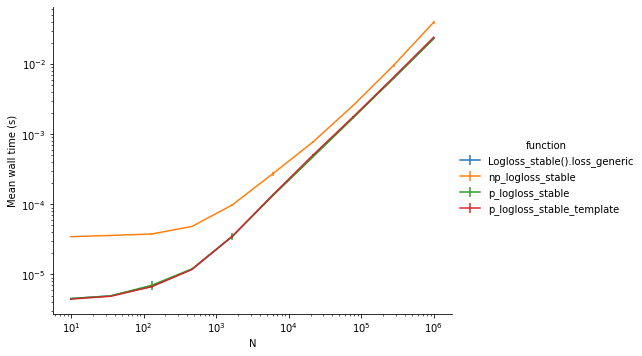

In [25]:
g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean wall time (s)")
g.add_legend()

In [26]:
df_reference = df.wall_time.reset_index().query("function == 'np_logloss_stable'")
df_plot = pd.merge(df.wall_time.reset_index(), df_reference, on='N', suffixes=('', '_np'))
df_plot['std'] = np.sqrt(df_plot['std']**2 / df_plot['mean_np']**2
                         + df_plot['mean']**2 / df_plot['mean_np']**4 * df_plot['std_np']**2)
df_plot['mean'] = df_plot['mean'] / df_plot['mean_np']
df_plot = df_plot.loc[:, ['N', 'function', 'mean', 'std']]
df_plot.head()

,N,function,mean,std
0,10,Logloss_stable().loss_generic,0.131152,0.004101
1,10,np_logloss_stable,1.000000,0.015466
2,10,p_logloss_stable,0.131203,0.002980
3,10,p_logloss_stable_template,0.128862,0.004214
4,35,Logloss_stable().loss_generic,0.137703,0.004816


In [27]:
# shift N slightly to make visualization easier
df_plot.loc[df_plot['function'] =='p_logloss_stable', 'N'] *= 0.95
df_plot.loc[df_plot['function'] =='Logloss_stable().loss_generic', 'N'] *= 1.05
df_plot.loc[df_plot['function'] =='p_logloss_stable_template', 'N'] *= 1.10

Text(0.5, 0.98, 'Ratio of wall time compared to np_logloss_stable')

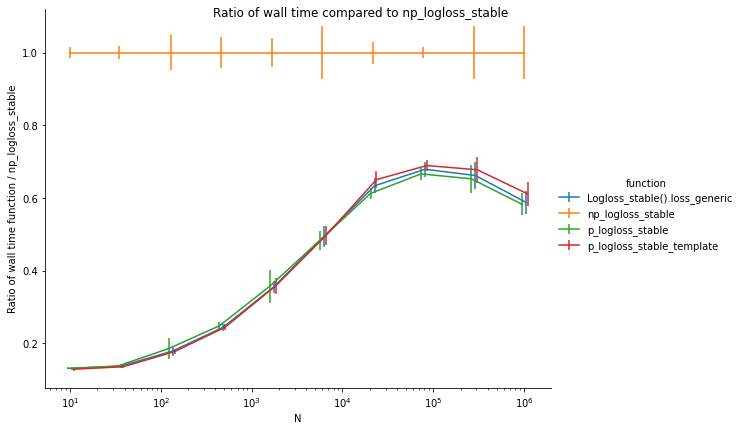

In [28]:
g = sns.FacetGrid(df_plot, hue="function", height=6, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
#g.set(ylim=(0.95, 2.5))
g.set(xscale="log")
g.set_axis_labels(y_var="Ratio of wall time function / np_logloss_stable")
g.add_legend()
g.fig.suptitle("Ratio of wall time compared to np_logloss_stable")

Text(0.5, 0.98, 'Ratio of wall time compared to np_logloss_stable')

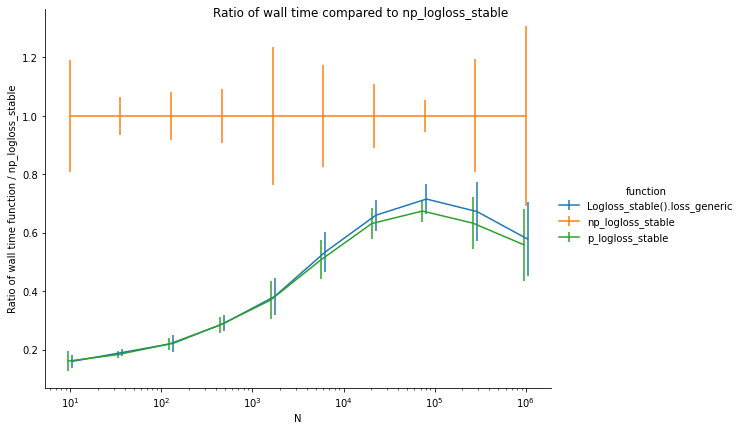

In [30]:
# OLD PLOT
#g = sns.FacetGrid(df_plot, hue="function", height=6, aspect=4/3)
#g.map_dataframe(errplot, "N", "mean", "std")
##g.set(ylim=(0.95, 2.5))
#g.set(xscale="log")
#g.set_axis_labels(y_var="Ratio of wall time function / np_logloss_stable")
#g.add_legend()
#g.fig.suptitle("Ratio of wall time compared to np_logloss_stable")

**Note: The small performance difference between `p_logloss_stable` and `Logloss_stable().loss_generic` stems from the fact that `p_logloss_stable` requires and assumes C-contiguous `y_true`.**

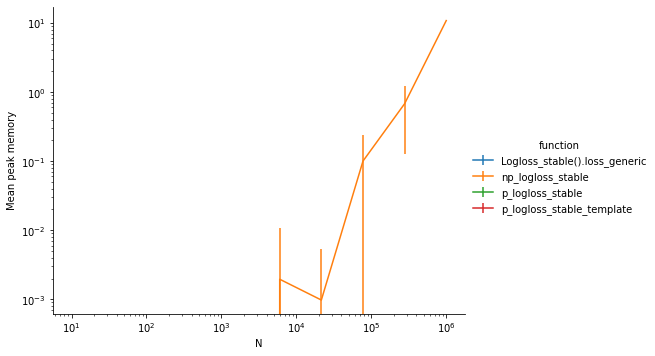

In [31]:
g = sns.FacetGrid(df.peak_memory.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean peak memory")
g.add_legend()